In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import copy

class DecisionTreeModel:
    def __init__(self):
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.accuracy = None
        self.core = None
        self.dataSet = None
        self.higCorCol = None
        self.preKey = None
        self.y_pred = None

        pass
    
    def AddDataSet(self, seed):
        #Check seed in valid form
        if isinstance(seed, pd.DataFrame):
            print("Insert successfully")
            self.dataSet = seed
        else:
            print("Can't insert. Check input frame again.")
    
    def TrainTestSplit(self):
        if self.dataSet is None or self.preKey is None:
            print("Insert dataset and prediction key first.")
            return
        key = self.preKey
        df = self.HighCorrelationRemove()
        df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
        self.x_test = df_test.drop(key, axis=1)
        self.y_test = df_test[key]
        #over sampling using smote
        smote = SMOTE(random_state=42)
        x_train = df_train.drop(key, axis=1)
        y_train = df_train[key]
        self.x_train, self.y_train = smote.fit_resample(x_train, y_train)
        

    def SetPredictionKey(self, key):
        if self.dataSet is None:
            print("Insert dataset (pandas data frame) first")
            return
        if key in self.dataSet.columns:
            self.preKey = key
            self.HighCorrelationDetect()
            self.TrainTestSplit()
            print("Insert successfully")
        else:
            print("Can't insert. Check input key again.")
    
    def Fit(self):
        if self.dataSet is None or self.preKey is None:
            print("Insert dataset and prediction key first.")
            return
        x_train, y_train = self.x_train, self.y_train
        core = DecisionTreeClassifier()
        core.fit(x_train, y_train)
        self.core = core
        print("Fit finish successfully!")

    def Prediction(self):
        if self.x_test is None or self.core is None:
            print("Insert dataset, prediction key and fit first.")
            return
        x_test = self.x_test
        y_pred = self.core.predict(x_test)
        self.y_pred = y_pred
        print("Accuracy for this prediction: ", self.Evaluation())

        return y_pred

    def Evaluation(self):
        if self.x_test is None or self.core is None:
            print("Insert dataset, prediction key and predict first.")
            return
        y_test, y_pred = self.y_test, self.y_pred
        self.accuracy = accuracy_score(y_test, y_pred)
        return self.accuracy

    def HighCorrelationDetect(self):
        exception = self.preKey
        threshold = 0.75
        df = copy.deepcopy(self.dataSet)
        columns = df.columns
        for label in columns:
            if df[label].dtype == 'object':
                df = df.drop(label, axis=1)
        #corr matrix
        corr_matrix = df.corr().abs()
        #result set
        result = list()
        #columns of corr matrix
        columns = corr_matrix.columns
        col_num = len(columns)
        #loop through the columns
        i = 0
        while i < col_num:
            for j in range(0, i):
                if exception != columns[i] \
                and corr_matrix.iloc[i, j] > threshold \
                and columns[i] not in result:
                    result.append(columns[i])
            i += 1
        self.higCorCol = result

    def HighCorrelationRemove(self):
        result = copy.deepcopy(self.dataSet)
        higCorCol = self.higCorCol
        for i in higCorCol:
            result.drop(i, axis=1)
        return result

    def PredictionDetails(self):
        y_test = self.y_test
        y_pred = self.y_pred
        print("Mark as possitive label: ", y_test[0])
        # Precision
        precision = precision_score(y_test, y_pred, pos_label=y_test[0])
        print("Precision:", precision)

        # Recall
        recall = recall_score(y_test, y_pred, pos_label=y_test[0])
        print("Recall:", recall)

        # F1-score
        f1 = f1_score(y_test, y_pred, pos_label=y_test[0])
        print("F1-score:",f1)

    def PredictionConfusionMatrix(self):
        y_test = self.y_test
        y_pred = self.y_pred
        # Create the confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Visualize the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        
    def report(self):
        if self.x_test is None or self.y_test is None or self.y_pred is None:
            print("Insert dataset, prediction key and predict first.")
            return
        y_test, y_pred = self.y_test, self.y_pred
        print(classification_report(y_test, y_pred))

In [18]:
df = pd.read_csv('./preProcessedDataWithHmdx.csv');
print(df);
dtm = DecisionTreeModel();
dtm.AddDataSet(df);
dtm.SetPredictionKey('HMDX_label');
dtm.Fit();
print("Prediction Set: ", dtm.Prediction());

      Year  Month  Day  Temp_mean  DewPoint_mean  RelHum_mean  \
0     2015      1    1     -5.092        -12.758       55.125   
1     2015      1    2     -1.729         -8.804       59.250   
2     2015      1    3     -1.417         -5.121       76.750   
3     2015      1    4      2.854          1.988       94.333   
4     2015      1    5     -7.196        -12.212       67.833   
...    ...    ...  ...        ...            ...          ...   
3434  2024      5   27     18.650         14.708       79.083   
3435  2024      5   28     17.042         13.283       79.042   
3436  2024      5   29     16.838          9.192       65.250   
3437  2024      5   30     14.888          2.279       43.875   
3438  2024      5   31     16.258          3.900       45.083   

      PrecipAmount_sum  StnPress_mean  HMDX HMDX_label  Temp_range  \
0                  0.0         99.931   0.0       Safe         4.4   
1                  0.0        100.519   0.0       Safe         2.4   
2        

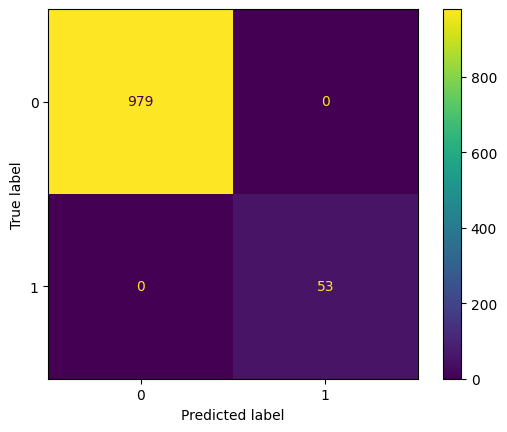

In [19]:
dtm.PredictionConfusionMatrix()

In [20]:
dtm.report()

              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00       979
      Unsafe       1.00      1.00      1.00        53

    accuracy                           1.00      1032
   macro avg       1.00      1.00      1.00      1032
weighted avg       1.00      1.00      1.00      1032



In [4]:
%pip install SMOTE
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import copy

class NaiveBayes:
    def __init__(self):
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.accuracy = None
        self.core = None
        self.dataSet = None
        self.higCorCol = None
        self.preKey = None
        self.y_pred = None
    
    def AddDataSet(self, seed):
        #Check seed in valid form
        if isinstance(seed, pd.DataFrame):
            print("Insert successfully")
            self.dataSet = seed
        else:
            print("Can't insert. Check input frame again.")
    
    def TrainTestSplit(self):
        if self.dataSet is None or self.preKey is None:
            print("Insert dataset and prediction key first.")
            return
        key = self.preKey
        df = self.HighCorrelationRemove()
        df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
        self.x_test = df_test.drop(key, axis=1)
        self.y_test = df_test[key]
        #over sampling using smote
        smote = SMOTE(random_state=42)
        x_train = df_train.drop(key, axis=1)
        y_train = df_train[key]
        self.x_train, self.y_train = smote.fit_resample(x_train, y_train)
        

    def SetPredictionKey(self, key):
        if self.dataSet is None:
            print("Insert dataset (pandas data frame) first")
            return
        if key in self.dataSet.columns:
            self.preKey = key
            self.HighCorrelationDetect()
            self.TrainTestSplit()
            print("Insert successfully")
        else:
            print("Can't insert. Check input key again.")
    
    def Fit(self):
        if self.dataSet is None or self.preKey is None:
            print("Insert dataset and prediction key first.")
            return
        x_train, y_train = self.x_train, self.y_train
        core = GaussianNB()
        core.fit(x_train, y_train)
        self.core = core
        print("Fit finish successfully!")

    def Prediction(self):
        if self.x_test is None or self.core is None:
            print("Insert dataset, prediction key and fit first.")
            return
        x_test = self.x_test
        y_pred = self.core.predict(x_test)
        self.y_pred = y_pred
        print("Accuracy for this prediction: ", self.Evaluation())

        return y_pred

    def Evaluation(self):
        if self.x_test is None or self.core is None:
            print("Insert dataset, prediction key and predict first.")
            return
        y_test, y_pred = self.y_test, self.y_pred
        self.accuracy = accuracy_score(y_test, y_pred)
        return self.accuracy

    def HighCorrelationDetect(self):
        exception = self.preKey
        threshold = 0.75
        df = copy.deepcopy(self.dataSet)
        columns = df.columns
        for label in columns:
            if df[label].dtype == 'object':
                df = df.drop(label, axis=1)
        #corr matrix
        corr_matrix = df.corr().abs()
        #result set
        result = list()
        #columns of corr matrix
        columns = corr_matrix.columns
        col_num = len(columns)
        #loop through the columns
        i = 0
        while i < col_num:
            for j in range(0, i):
                if exception != columns[i] \
                and corr_matrix.iloc[i, j] > threshold \
                and columns[i] not in result:
                    result.append(columns[i])
            i += 1
        self.higCorCol = result

    def HighCorrelationRemove(self):
        result = copy.deepcopy(self.dataSet)
        higCorCol = self.higCorCol
        for i in higCorCol:
            result.drop(i, axis=1)
        return result

    def PredictionDetails(self):
        y_test = self.y_test
        y_pred = self.y_pred
        print("Mark as possitive label: ", y_test[0])
        # Precision
        precision = precision_score(y_test, y_pred, pos_label=y_test[0])
        print("Precision:", precision)

        # Recall
        recall = recall_score(y_test, y_pred, pos_label=y_test[0])
        print("Recall:", recall)

        # F1-score
        f1 = f1_score(y_test, y_pred, pos_label=y_test[0])
        print("F1-score:",f1)

    def PredictionConfusionMatrix(self):
        y_test = self.y_test
        y_pred = self.y_pred
        # Create the confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Visualize the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        
    def report(self):
        if self.x_test is None or self.y_test is None or self.y_pred is None:
            print("Insert dataset, prediction key and predict first.")
            return
        y_test, y_pred = self.y_test, self.y_pred
        print(classification_report(y_test, y_pred))


In [13]:
df = pd.read_csv('./preProcessedDataWithHmdx.csv')
nbm = NaiveBayes()
nbm.AddDataSet(df)
nbm.SetPredictionKey('HMDX_label')
nbm.Fit()
nbm.Prediction()

Insert successfully
Insert successfully
Fit finish successfully!
Accuracy for this prediction:  0.9563953488372093


array(['Unsafe', 'Safe', 'Unsafe', ..., 'Safe', 'Safe', 'Safe'],
      dtype='<U6')

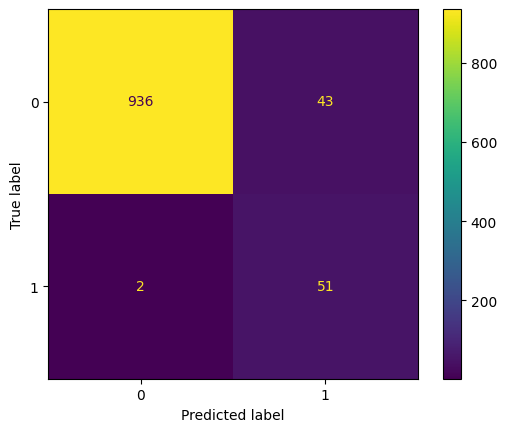

In [14]:
nbm.PredictionConfusionMatrix()

In [15]:
nbm.report()

              precision    recall  f1-score   support

        Safe       1.00      0.96      0.98       979
      Unsafe       0.54      0.96      0.69        53

    accuracy                           0.96      1032
   macro avg       0.77      0.96      0.84      1032
weighted avg       0.97      0.96      0.96      1032

